The idea behind this project is to use imagery from the Sloan Digital Sky Survey, an ongoing sky survey that (among other data) has compiled imagery of roughly 35% of the sky, to train a deep learning model to classify images of galaxies according to their morphological structure.

Galaxies fall into 4 broad morphological types:
- Elliptical galaxies, which look like diffuse, featureless ellipsoids.
- Spiral galaxies, which look like the classic "disc with spiral arms" shape that galaxies are usually depicted as;
- Lenticular galaxies, which are an intermediate class consisting of a bright central bulge surrounded by a diffuse disc with no spiral structure;
- Irregular galaxies, which do not have a discernable greater structure.
  
This classification is known as the "Hubble sequence".

For training data, we use the New General and Index Catalogues, two 19th-century directory of 13,226 galaxies, nebulae, star clusters, and other miscellaneous deep-sky objects.

These objects are compiled in csv format here: https://github.com/mattiaverga/OpenNGC?tab=readme-ov-file, including corrections of many errors / duplicated objects.

This databse includes their position in the sky in the right ascension / declination coordinate system, their angular size, and the Hubble classification of most included galaxies.
We use this data to pull imagery of every galaxy from the SDSS using their ImgCutout API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import os
ngc_ic_raw = pd.read_csv("OpenNGC-master/database_files/NGC.csv", sep=';', index_col=False)
ngc_ic_raw.head()

,Name,Type,RA,Dec,Const,MajAx,MinAx,PosAng,B-Mag,V-Mag,...,Cstar V-Mag,M,NGC,IC,Cstar Names,Identifiers,Common names,NED notes,OpenNGC notes,Sources
0,IC0001,**,00:08:27.05,+27:43:03.6,Peg,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99
1,IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142.0,15.46,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -0...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
2,IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53.0,14.78,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
3,IC0004,G,00:13:26.94,+17:29:11.2,Peg,1.17,0.84,12.0,14.14,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00132695+1729111,IRAS 00108+1712,MCG +0...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
4,IC0005,G,00:17:34.93,-09:32:36.1,Cet,0.99,0.66,9.0,14.57,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00173495-0932364,MCG -02-01-047,PGC 001...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...


We trim the dataset to include only galaxies with a provided Hubble class which are not part of a galaxy pair/triple/group (in order to have a clear view of the labeled galaxy.) We also ignore all columns not relevant to us - we only need the location in the sky, angular size, and Hubble class. (The majority of the objects in the NGC / IC catalogues are galaxies, so we still have plenty of data.)

In [2]:
# Trim dataset to include galaxies with a specified Hubble class only.
ngc_ic_galaxies = ngc_ic_raw[(ngc_ic_raw['Type'] == 'G') & (~pd.isnull(ngc_ic_raw['Hubble']))]
# Many (but not all) members of galaxy pairs can be identified by an NED suffix on their entry in the database.
ngc_ic_solo_galaxies = ngc_ic_galaxies[ngc_ic_galaxies['Name'].apply(lambda x : 'NED' not in x)]
ngc_ic = ngc_ic_solo_galaxies[['Name', 'RA', 'Dec', 'MajAx', 'Hubble']]
ngc_ic.shape

(9857, 5)

In [3]:
# Currently, right ascension and declination are given in non-decimal units and as strings; convert to decimal.
def RA_HMS_to_dec_deg(HMS):
    HMS_list = HMS.split(':')
    hours, minutes, seconds = float(HMS_list[0]), float(HMS_list[1]), float(HMS_list[2])
    deg = 15*hours + 0.25*minutes + (1/240)*seconds
    return deg

def DEC_DMS_to_dec_deg(DMS):
    sign = DMS[0]
    if sign == '+':
        sign = 1
    elif sign == '-':
        sign = -1
    else:
        raise ValueError('Object declination does not begin with sign')
    DMS_list = DMS[1:].split(':')
    degrees, minutes, seconds = float(DMS_list[0]), float(DMS_list[1]), float(DMS_list[2])
    deg = sign*(degrees + (1/60)*minutes + (1/3600)*seconds)
    return deg

ngc_ic.loc[:, 'RA_decimal'] = ngc_ic.loc[:, 'RA'].apply(RA_HMS_to_dec_deg)
ngc_ic.loc[:, 'Dec_decimal'] = ngc_ic.loc[:, 'Dec'].apply(DEC_DMS_to_dec_deg)

/var/folders/pj/d1crch5j30s__4vxlk7nq4140000gn/T/ipykernel_55470/3258966821.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngc_ic.loc[:, 'RA_decimal'] = ngc_ic.loc[:, 'RA'].apply(RA_HMS_to_dec_deg)
/var/folders/pj/d1crch5j30s__4vxlk7nq4140000gn/T/ipykernel_55470/3258966821.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngc_ic.loc[:, 'Dec_decimal'] = ngc_ic.loc[:, 'Dec'].apply(DEC_DMS_to_dec_deg)


The SDSS does not cover the full sky - their coverage map is avaliable here: https://classic.sdss.org/dr7/coverage/
We drop all objects lying outside a rectangle positioned inside the bulk of the coverage. This still leaves over 4000 objects for training:

In [4]:
# SDSS imagery does not cover the whole sky - we filter RA and DEC so that all objects lie in the bulk of the SDSS coverage zone.
SDSS_imagery = (ngc_ic['Dec_decimal'] > 0) & (ngc_ic['Dec_decimal'] < 60) & (ngc_ic['RA_decimal'] > 120) & (ngc_ic['RA_decimal'] < 240)
ngc_ic_SDSS_imagery = ngc_ic[SDSS_imagery]
ngc_ic_SDSS_imagery.shape

(3902, 7)

We choose to attempt to scale each object so that they have the same apparent size in our training images. ImgCutout requests both an image size and a resolution in arcsec / pixel (between 0.015 and 60). Resolutions near the lower limit result in poor-quality imagery, so we use a lower bound of 0.1 instead.

In [12]:
# We use the major axis to compute this scale.
image_size = 256
padding = 1.25
violated_bounds = []

def create_resolution(row, image_size, padding):
    MajAxArcsec = row['MajAx'] * 60
    res = MajAxArcsec * padding / image_size
    min_allowed_res = 0.1
    max_allowed_res = 60
    bounded_res = sorted([min_allowed_res, res, max_allowed_res])[1]  
    # check which objects bump up against the resolution bounds:
    if bounded_res == min_allowed_res or bounded_res == max_allowed_res:
        violated_bounds.append(row['Name'])
    return bounded_res

ngc_ic_SDSS_imagery.loc[:, 'image_res'] = ngc_ic_SDSS_imagery.apply(lambda x : create_resolution(x, image_size, padding), axis=1)
print('Objects which are too small / too big: ' + str(violated_bounds))
print(str(len(violated_bounds)) + ' objects are too small / big to fit neatly in an image.')

Objects which are too small / too big: ['IC0694', 'IC0921', 'IC0928', 'IC0931', 'IC2249', 'IC2614', 'IC2619', 'IC2657', 'IC2676', 'IC2719', 'IC2742', 'IC2753', 'IC2765', 'IC2771', 'IC2775', 'IC2779', 'IC2807', 'IC2821', 'IC2838', 'IC2847', 'IC2858', 'IC2860', 'IC2883', 'IC2886', 'IC2900', 'IC3022', 'IC3074', 'IC3110', 'IC3128B', 'IC3135', 'IC3179', 'IC3287', 'IC3324', 'IC3335', 'IC3345', 'IC3372', 'IC3396', 'IC3449', 'IC3469', 'IC3479', 'IC3494', 'IC3528', 'IC3558', 'IC3565', 'IC3582', 'IC3610', 'IC3614', 'IC3622', 'IC3649', 'IC3655', 'IC3657', 'IC3678', 'IC3723', 'IC3729', 'IC3751', 'IC3761', 'IC3771', 'IC3785', 'IC3786', 'IC3817', 'IC3842', 'IC3847', 'IC3870', 'IC3872', 'IC3897', 'IC3898', 'IC3928', 'IC3948', 'IC3954', 'IC3965', 'IC3994', 'IC4007', 'IC4018', 'IC4031', 'IC4063', 'IC4085', 'IC4087', 'IC4102', 'IC4110', 'IC4140', 'IC4159', 'IC4162', 'IC4184', 'IC4284', 'IC4300', 'NGC2735A', 'NGC3690A', 'NGC4465', 'NGC5679C', 'NGC5896', 'NGC6027D']
91 objects are too small / big to fit n

Next, we build the links to access the SDSS imagery. They are of the format:
https://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra={RA}&dec={DEC}&width={IMG_WIDTH}&height={IMG_HEIGHT}&scale={IMG_RES}

In [14]:
def produce_link(row, image_size):
    url_0 = "https://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra="
    url_1 = "&dec="
    url_2 = "&width="
    url_3 = "&height="
    url_4 = "&scale="

    ra = str(row['RA_decimal'])
    dec = str(row['Dec_decimal'])
    scale = str(row['image_res'])

    return url_0 + str(ra) + url_1 + str(dec) + url_2 + str(image_size) + url_3 + str(image_size) + url_4 + str(scale)

ngc_ic_SDSS_imagery.loc[:, 'image_link'] = ngc_ic_SDSS_imagery.apply(lambda x : produce_link(x, image_size), axis=1)
ngc_ic_SDSS_imagery.loc[921, 'image_link'] # output example link

'https://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra=200.14725&dec=34.1395&width=256&height=256&scale=0.23144531250000003'

We now iterate over these links and download them, grouping them by their Hubble classification. We also store the image filepaths in the dataframe.

In [ ]:
def get_filepath(row):
    object_name = row['Name']
    object_class = row['Hubble']
    folder = 'imagery_fine/{}'.format(object_class)
    filename = folder + '/{}.jpg'.format(object_name)
    return [filename, folder]
    
def get_image(row):
    filename, folder = get_filepath(row)
    if not os.path.exists(folder):
        os.makedirs(folder)
    url = row['image_link']
    urllib.request.urlretrieve(url, filename) 
    return filename


ngc_ic_SDSS_imagery['image_filepath'] = ngc_ic_SDSS_imagery.apply(get_image, axis=1)
ngc_ic_SDSS_imagery.head()
# ways to improve:
## omit single members of galaxy pairs / triples - identfy by NED suffix
## filter out galaxies that require too small a resolution
## Should include a matplotlib demo of the images.
## May also want to section off some test data.

/var/folders/pj/d1crch5j30s__4vxlk7nq4140000gn/T/ipykernel_55470/251833492.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ngc_ic_SDSS_imagery['image_filepath'] = ngc_ic_SDSS_imagery.apply(get_image, axis=1)


,Name,RA,Dec,MajAx,Hubble,RA_decimal,Dec_decimal,image_res,image_link,Hubble_coarse,image_filepath
498,IC0484,08:00:01.06,+26:39:57.1,0.89,Sb,120.004417,26.665861,0.260742,https://skyservice.pha.jhu.edu/DR7/ImgCutout/g...,spiral,imagery_fine/Sb/IC0484.jpg
499,IC0485,08:00:19.77,+26:42:05.2,1.17,SABa,120.082375,26.701444,0.342773,https://skyservice.pha.jhu.edu/DR7/ImgCutout/g...,spiral,imagery_fine/SABa/IC0485.jpg
500,IC0486,08:00:20.98,+26:36:48.7,0.87,SBa,120.087417,26.613528,0.254883,https://skyservice.pha.jhu.edu/DR7/ImgCutout/g...,spiral,imagery_fine/SBa/IC0486.jpg
504,IC0490,08:03:20.12,+25:48:41.1,0.59,Sbc,120.833833,25.811417,0.172852,https://skyservice.pha.jhu.edu/DR7/ImgCutout/g...,spiral,imagery_fine/Sbc/IC0490.jpg
505,IC0491,08:03:55.00,+26:31:14.2,0.65,Sc,120.979167,26.520611,0.190430,https://skyservice.pha.jhu.edu/DR7/ImgCutout/g...,spiral,imagery_fine/Sc/IC0491.jpg


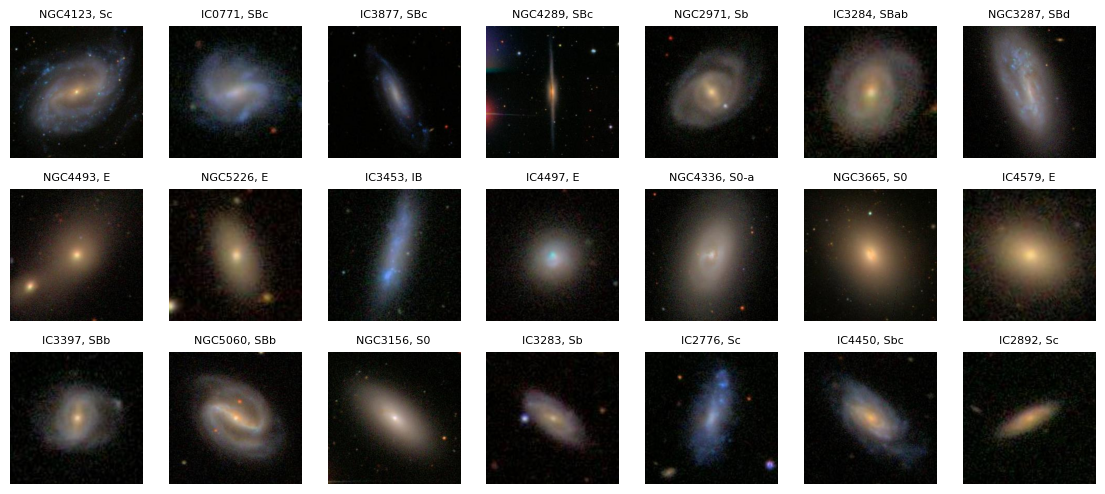

In [20]:
grid_rows = 3
grid_cols = 7

def sample_images(rows, cols, df):
    galaxies = df.sample(rows*cols)
    fig, axs_array = plt.subplots(rows, cols, figsize = (cols*2, rows*2))
    axs = axs_array.flatten()
    i = 0
    for ax in axs:
        galaxy = galaxies.iloc[i]
        path = get_filepath(galaxy)[0]
        ax.imshow(np.asarray(Image.open(path)))
        title = str(galaxy['Name']) + ', ' + str(galaxy['Hubble'])
        ax.set_title(title, fontsize = 8)
        ax.set_axis_off()
        i += 1
    
sample_images(grid_rows, grid_cols, ngc_ic_SDSS_imagery)
    

The Hubble types provided in the dataset are much more specific than the four broad types outlined above, with subclassifications based on how tightly wound a spiral galaxy's arms are, the presence of a central bar, and faint spiral structures visible in some irregular galaxies. We group these subclassifications togehter:

In [26]:
coarse_hubble_types={
    'elliptical' : ['E', 'E?'],
    'lenticular' : ['S0', 'E-S0', 'S0-a', 'S?'],
    'spiral' : ['Sa', 'Sab', 'Sb', 'Sbc', 'Sc', 'Scd', # ordinary spirals
              'SABa', 'SABab', 'SABb', 'SABbc', 'SABc', 'SABcd', 'SABd', # weakly barred spirals
              'SBa', 'SBab', 'SBb', 'SBbc', 'SBc' ,'SBcd', 'SBd' ], # barred spirals
    'irregular' : ['Sd', 'SABd', 'SBd', # weak spirals
                 'Sm', 'SBm', 'SABm',
                 'I', 'IB', 'IAB']}
def coarse_hubble_type(row):
    for key, value in coarse_hubble_types.items():
        if row['Hubble'] in value:
            return key
    raise ValueError('No coarse hubble type for input.')

ngc_ic_SDSS_imagery.loc[:, 'Hubble_coarse'] = ngc_ic_SDSS_imagery.apply(coarse_hubble_type, axis=1)
ngc_ic_SDSS_imagery['Hubble_coarse'].value_counts()

image_labels = ngc_ic_SDSS_imagery[['image_filepath', 'Hubble_coarse']]
image_labels.set_index('image_filepath')
image_labels.to_csv('image_labels.csv')